# Germinal center: exclusion of t-cells in the dark zone: 
---
## Using nmco to characterise exclusion of tcells by dark zone cellls


Data (from Claudio, IFOM): 
10 images depicting germinal centers (annotated by hand) stained for Dapi, CD3 and AICDA (dataset_1).

Models computed:
We identified dark zone, light zone cells and t-cells using cellular levels of biomarkers.

We have trained RF models to distinguish between dark and light zone bcells and cells within and outside the tcell zone of influence using their nmco features.

Aim:
1. To compute the fraction of dark zone or light zone cells that are interating with t-cells. 
2. Does the probability of a cell being in a dark zone cell, as predicted by the model negatively correlate with the probability of interaction with t-cells?

In [1]:
# import libraries
import sys
sys.path.append("..")

from pathlib import Path
from glob import glob
import pandas as pd
import numpy as np
import os
import _pickle as cPickle
import matplotlib.pyplot as plt
from tifffile import imread

import scipy.stats as ss

In [2]:
# read in the data
path_to_raw_images = '/media/pathy_s/54fe7289-2a61-4f3a-ac84-eeea3c0d1d2f/ifom_germinal_centers/dataset_1/' 
data_dir = path_to_raw_images + "consolidated_data/"

nuc_features = pd.read_csv(os.path.join(data_dir, "nuc_features.csv"), index_col=0)
nuc_features.index= nuc_features['nuc_id']

spatial_cord = pd.read_csv(os.path.join(data_dir, "spatial_coordiates.csv"), index_col=0)
spatial_cord.index= spatial_cord['nuc_id']

output_dir = '/media/pathy_s/54fe7289-2a61-4f3a-ac84-eeea3c0d1d2f/ifom_germinal_centers/code/analysis_resources/'
Path(output_dir).mkdir(parents=True, exist_ok=True)

cell_type_pred = pd.read_csv(os.path.join(os.path.join(output_dir, 'discriminating_2_celltypes'), 'model_predictions.csv'))
cell_type_pred.index= cell_type_pred['nuc_id']

tcell_interaction_pred = pd.read_csv(os.path.join(os.path.join(output_dir, 't_cell_zone_of_influence'), 'model_predictions.csv'))
tcell_interaction_pred.index= tcell_interaction_pred['nuc_id']



### Summarizing the data

We read in the feature tables and results of the celltype detection and model predictions and for each germinal center, we compute the following 

1. number of cells of each type, 
2. how many are interacting with the tcells, and 
3. how is the probility of a cell being in the dark zone correlated to that of it being a tcell interactor?


In [3]:
# summarizing the data and the model predictions
grouped = nuc_features.groupby(nuc_features.image)
image_ids = list(set(grouped.keys))

#setting up variables 
num_dz_cells = []
num_lz_cells = []
num_tcells = []
num_tcell_int = []
num_tcell_non = []
num_dz_tcell_int = []
num_lz_tcell_int = []
num_dz_tcell_non = []
num_lz_tcell_non =[]
pcc_coefficient = []
pcc_pvalue = []
src_coefficient =[]
src_pvalue = []


for i in range(len(image_ids)):
    #subet the data
    data = grouped.get_group(image_ids[i])
    actual_celltype = cell_type_pred.loc[list(set(data.index) & set(cell_type_pred.index)),'actual_stage']
    actual_tcell_int = tcell_interaction_pred.loc[list(set(data.index) & set(tcell_interaction_pred.index)),'actual_stage']

    # calculate the number of cells (dark or light) that are interacting/noninteracting with tcells 
    dz_cells = list(actual_celltype[actual_celltype == 'dark_b_cells'].index)
    num_dz_cells.append(len(dz_cells))
    lz_cells = list(actual_celltype[actual_celltype == 'light_b_cells'].index)
    num_lz_cells.append(len(lz_cells))
    t_cells = list( set(actual_celltype.index) - set(actual_tcell_int.index))
    num_tcells.append(len(t_cells))

    num_tcell_int.append(len(actual_tcell_int[actual_tcell_int == 'within_t_cell_zone'].index))
    num_tcell_non.append(len(actual_tcell_int[actual_tcell_int == 'outside_t_cell_zone'].index))

    tcell_int_dz = list(set(actual_tcell_int[actual_tcell_int == 'within_t_cell_zone'].index) &
                        set(dz_cells))
    num_dz_tcell_int.append(len(tcell_int_dz))

    tcell_int_lz = list(set(actual_tcell_int[actual_tcell_int == 'within_t_cell_zone'].index) &
                        set(lz_cells))
    num_lz_tcell_int.append(len(tcell_int_lz))

    tcell_non_dz = list(set(actual_tcell_int[actual_tcell_int == 'outside_t_cell_zone'].index) &
                        set(dz_cells))
    num_dz_tcell_non.append(len(tcell_non_dz))

    tcell_non_lz = list(set(actual_tcell_int[actual_tcell_int == 'outside_t_cell_zone'].index) &
                        set(lz_cells))
    num_lz_tcell_non.append(len(tcell_non_lz))

    #find the corelation between the probability of a cell being in the dark zone and that of it interacting with a tcell 
    interaction_prob = tcell_interaction_pred.loc[list(set(data.index) & set(tcell_interaction_pred.index)), 'prob_within_t_cell_zone']
    dark_zone_prob = cell_type_pred.loc[list(set(data.index) & set(tcell_interaction_pred.index)), 'prob_dark_b_cells']

    src_coeff,src_p = ss.spearmanr(interaction_prob,dark_zone_prob)
    pcc_coeff,pcc_p = ss.pearsonr(interaction_prob,dark_zone_prob)

    src_coefficient.append(src_coeff)
    src_pvalue.append(src_p)
    pcc_coefficient.append(pcc_coeff)
    pcc_pvalue.append(pcc_p)

results = pd.DataFrame ({ 'num_dz_cells' : num_dz_cells,
                          'num_lz_cells' : num_lz_cells,
                          'num_t_cells' : num_tcells,
                          'num_tcell_int' : num_tcell_int,
                          'num_tcell_non' : num_tcell_non,
                          'num_dz_tcell_int' : num_dz_tcell_int,
                          'num_lz_tcell_int' : num_lz_tcell_int,
                          'num_dz_tcell_non' : num_dz_tcell_non,
                          'num_lz_tcell_non' : num_lz_tcell_non,
                          'pcc_coefficient' : pcc_coefficient,
                          'pcc_pvalue' : pcc_pvalue, 
                          'src_coefficient' : src_coefficient, 
                          'src_pvalue' : src_pvalue, 
                          'image' : image_ids})
results['frac_dz_tcell_int'] = results.num_dz_tcell_int/results.num_dz_cells
results['frac_lz_tcell_int'] = results.num_lz_tcell_int/results.num_lz_cells

results['frac_tcell_int_dz'] = results.num_dz_tcell_int/results.num_tcell_int
results['frac_tcell_int_lz'] = results.num_lz_tcell_int/results.num_tcell_int

results['frac_tcell_non_dz'] = results.num_dz_tcell_non/results.num_tcell_non
results['frac_tcell_non_lz'] = results.num_lz_tcell_non/results.num_tcell_non

## Fraction of germinal center cells types interacting with t-cells


Number of observations = 10
pvalue of homogeneity test = 1.0
pvalue of normality tests = 0.7255737781524658 & 0.7255710363388062
pvalue of ttest = 2.217875863206935e-11


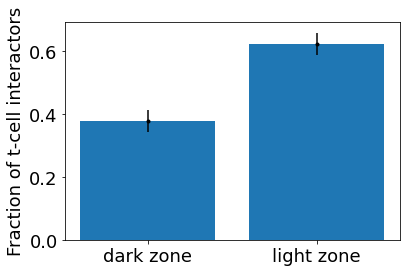

In [4]:
# fraction of cells that are interacting with t-cells
plt.rcParams.update({ 'font.size': 18})
a = results['frac_tcell_int_dz']
b = results['frac_tcell_int_lz']
names = ['dark zone','light zone']
means = [np.mean(a), np.mean(b)]
error = [np.std(a), np.std(b)]

plt.bar( names, means)
plt.errorbar(names, means, yerr = error, fmt = '.k', color = 'k')
plt.ylabel('Fraction of t-cell interactors')

# significance test
print('Number of observations = {}'.format(len(image_ids)))
print('pvalue of homogeneity test = {}'.format(ss.levene(a,b)[1]))
print('pvalue of normality tests = {} & {}'.format(ss.shapiro(a)[1],
                                                  ss.shapiro(b)[1]))
print('pvalue of ttest = {}'.format(ss.ttest_ind(a,b)[1]))

We see that of the cells within a germinal center that are interacting with a tcell, most of them are in the light zone and this difference is statistically significant. 

## Relationship between the tcell interactors and dark zone cells as learnt by the model

Number of observations = 10
pvalue of homogeneity test = 0.20584130362727687
pvalue of normality tests = 0.35121387243270874 & 0.2826014459133148
pvalue of ttest = 0.15472410311438906


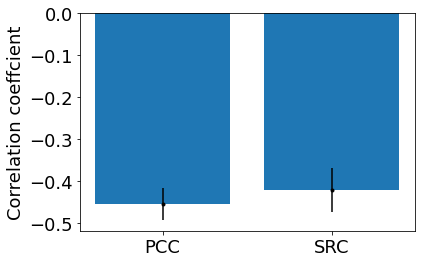

In [5]:
# correlation
plt.rcParams.update({ 'font.size': 18})
a = results['pcc_coefficient']
b = results['src_coefficient']
names = ['PCC','SRC']
means = [np.mean(a), np.mean(b)]
error = [np.std(a), np.std(b)]

plt.bar( names, means)
plt.errorbar(names, means, yerr = error, fmt = '.k', color = 'k')
plt.ylabel('Correlation coeffcient')

# significance test
print('Number of observations = {}'.format(len(image_ids)))
print('pvalue of homogeneity test = {}'.format(ss.levene(a,b)[1]))
print('pvalue of normality tests = {} & {}'.format(ss.shapiro(a)[1],
                                                  ss.shapiro(b)[1]))
print('pvalue of ttest = {}'.format(ss.ttest_ind(a,b)[1]))

Text(0.5, 0, 'Probability: t-cell interactor')

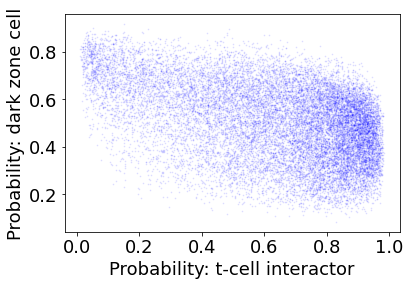

In [6]:
interaction_prob = tcell_interaction_pred.loc[tcell_interaction_pred.index, 'prob_within_t_cell_zone']
dark_zone_prob = cell_type_pred.loc[tcell_interaction_pred.index, 'prob_dark_b_cells']

plt.scatter(interaction_prob,dark_zone_prob,s=0.5, alpha=0.1, color= 'b')
plt.ylabel('Probability: dark zone cell')
plt.xlabel('Probability: t-cell interactor')

We find that the probility of a cell being a t cell interactor is negatively correlatied with its probility of being a dark zone cell. this suggests that the nmco features capabe of capturing the tcell exclusion in the dark zone.

## Visualizing the prediction probabilities in space

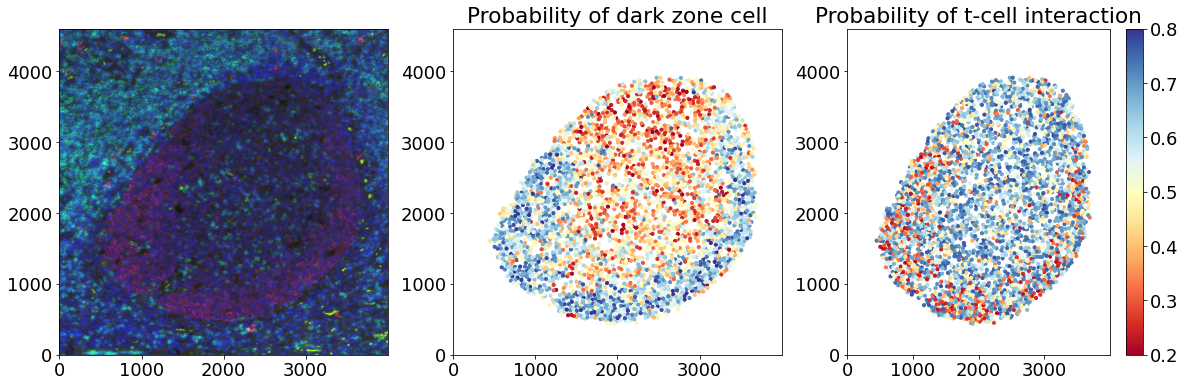

In [7]:
image_id = 1
img_path = os.path.join(os.path.join(path_to_raw_images,"images"),str(image_id)+".tif")

image = imread(img_path)
data = grouped.get_group(image_id)
x = spatial_cord.loc[list(set(data.index) & set(tcell_interaction_pred.index)),'centroid-0']
y = spatial_cord.loc[list(set(data.index) & set(tcell_interaction_pred.index)),'centroid-1']

dz_prob = cell_type_pred.loc[list(set(data.index) & set(tcell_interaction_pred.index)),'prob_dark_b_cells']
int_prob = tcell_interaction_pred.loc[list(set(data.index) & set(tcell_interaction_pred.index)),'prob_within_t_cell_zone']
dz_pred = cell_type_pred.loc[list(set(data.index) & set(tcell_interaction_pred.index)),'actual_stage']
int_pred = tcell_interaction_pred.loc[list(set(data.index) & set(tcell_interaction_pred.index)),'actual_stage']

fig = plt.figure(figsize=(20, 6))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

ax0.imshow(image,aspect='auto', origin ='lower') 
img1 = ax1.scatter(y,x, c=(dz_prob),
                     s=10,cmap='RdYlBu',
                    vmin=0.2, vmax=0.8)
ax1.set_title('Probability of dark zone cell')
ax1.set_ylim(0,image.shape[0])
ax1.set_xlim(0,image.shape[1])

img2 = ax2.scatter(y,x, c=(int_prob),
                     s=10,cmap='RdYlBu',
                    vmin=0, vmax=1)
ax2.set_title('Probability of t-cell interaction')
ax2.set_ylim(0,image.shape[0])
ax2.set_xlim(0,image.shape[1])
plt.colorbar(img1)

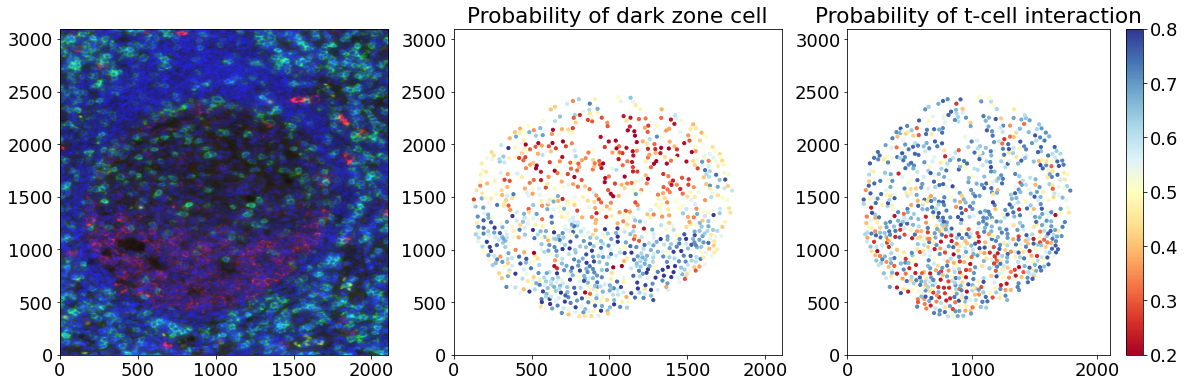

In [8]:
image_id = 5
img_path = os.path.join(os.path.join(path_to_raw_images,"images"),str(image_id)+".tif")

image = imread(img_path)
data = grouped.get_group(image_id)
x = spatial_cord.loc[list(set(data.index) & set(tcell_interaction_pred.index)),'centroid-0']
y = spatial_cord.loc[list(set(data.index) & set(tcell_interaction_pred.index)),'centroid-1']

dz_prob = cell_type_pred.loc[list(set(data.index) & set(tcell_interaction_pred.index)),'prob_dark_b_cells']
int_prob = tcell_interaction_pred.loc[list(set(data.index) & set(tcell_interaction_pred.index)),'prob_within_t_cell_zone']
dz_pred = cell_type_pred.loc[list(set(data.index) & set(tcell_interaction_pred.index)),'actual_stage']
int_pred = tcell_interaction_pred.loc[list(set(data.index) & set(tcell_interaction_pred.index)),'actual_stage']

fig = plt.figure(figsize=(20, 6))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

ax0.imshow(image,aspect='auto', origin ='lower') 
img1 = ax1.scatter(y,x, c=(dz_prob),
                     s=10,cmap='RdYlBu',
                    vmin=0.2, vmax=0.8)
ax1.set_title('Probability of dark zone cell')
ax1.set_ylim(0,image.shape[0])
ax1.set_xlim(0,image.shape[1])

img2 = ax2.scatter(y,x, c=(int_prob),
                     s=10,cmap='RdYlBu',
                    vmin=0, vmax=1)
ax2.set_title('Probability of t-cell interaction')
ax2.set_ylim(0,image.shape[0])
ax2.set_xlim(0,image.shape[1])
plt.colorbar(img1)